In [3]:
!pip install prophet

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [86]:
pjme = pd.read_csv('/content/mock_kaggle.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.index = pd.to_datetime(pjme.index)
pjme.head()

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


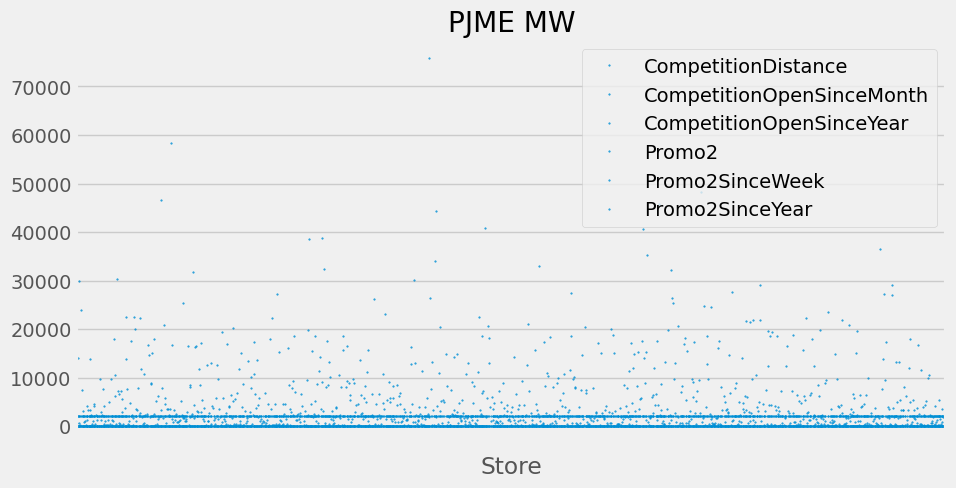

In [81]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

TIME SERIES FEATURES


In [89]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='venda')
features_and_target = pd.concat([X, y], axis=1)

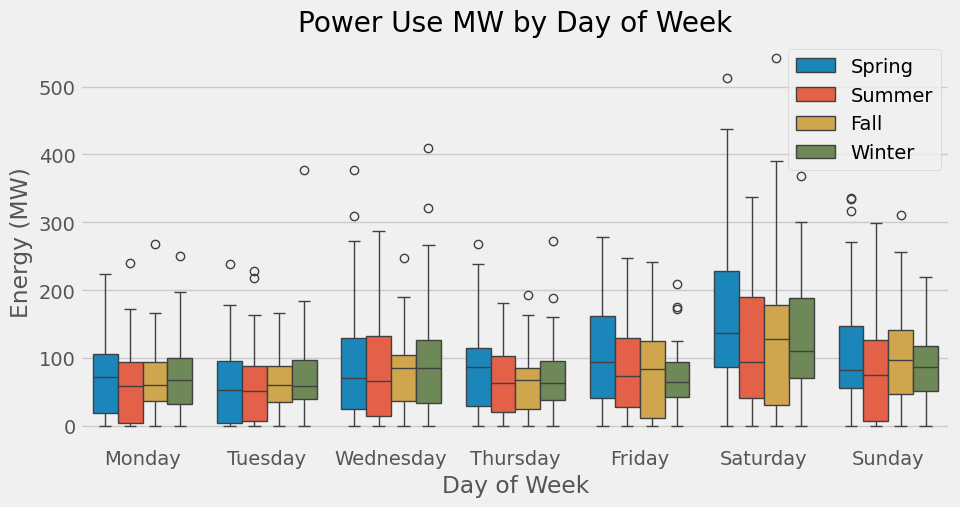

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='venda',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

TRAIN/TEST SPLIT

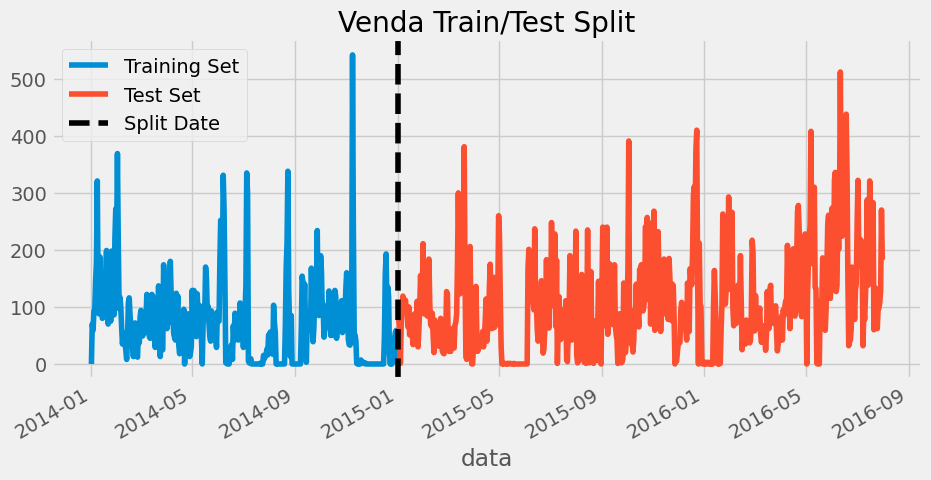

In [25]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
fig, ax = plt.subplots(figsize=(10, 5))
pjme_train['venda'].plot(ax=ax, label='Training Set', title='Venda Train/Test Split')
pjme_test['venda'].plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='k', linestyle='--', label='Split Date')
ax.legend()
plt.show()

SIMPLE PROPHET MODEL

In [28]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'data':'ds',
                     'venda':'y'})

In [30]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7icd2v_/f7nbvyf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7icd2v_/d8vdxfox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22622', 'data', 'file=/tmp/tmp_7icd2v_/f7nbvyf8.json', 'init=/tmp/tmp_7icd2v_/d8vdxfox.json', 'output', 'file=/tmp/tmp_7icd2v_/prophet_modelyh5sqw9i/prophet_model-20250920163253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 45.3 ms, sys: 3.22 ms, total: 48.6 ms
Wall time: 77.8 ms


In [33]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'data':'ds',
                     'venda':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [34]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,41.541548,-44.194822,124.229650,41.541548,41.541548,-2.497732,-2.497732,-2.497732,-2.497732,-2.497732,-2.497732,0.0,0.0,0.0,39.043816
1,2015-01-03,41.384587,-2.824966,163.650566,41.384587,41.384587,44.082928,44.082928,44.082928,44.082928,44.082928,44.082928,0.0,0.0,0.0,85.467515
2,2015-01-04,41.227626,-30.071257,143.925596,41.227626,41.227626,9.956704,9.956704,9.956704,9.956704,9.956704,9.956704,0.0,0.0,0.0,51.184331
3,2015-01-05,41.070665,-66.442733,107.298689,41.070627,41.070665,-18.067184,-18.067184,-18.067184,-18.067184,-18.067184,-18.067184,0.0,0.0,0.0,23.003481
4,2015-01-06,40.913704,-65.469592,92.422813,40.913610,40.913737,-21.561516,-21.561516,-21.561516,-21.561516,-21.561516,-21.561516,0.0,0.0,0.0,19.352189


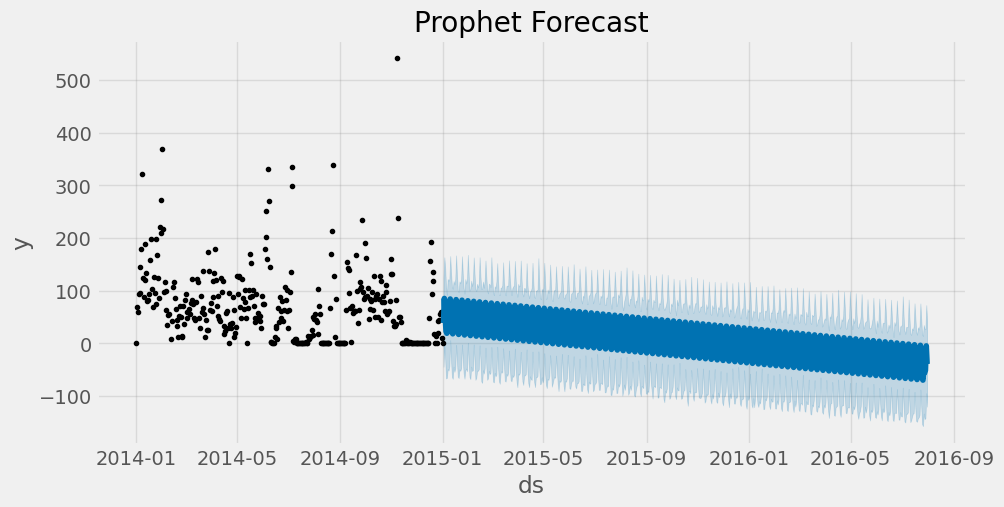

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

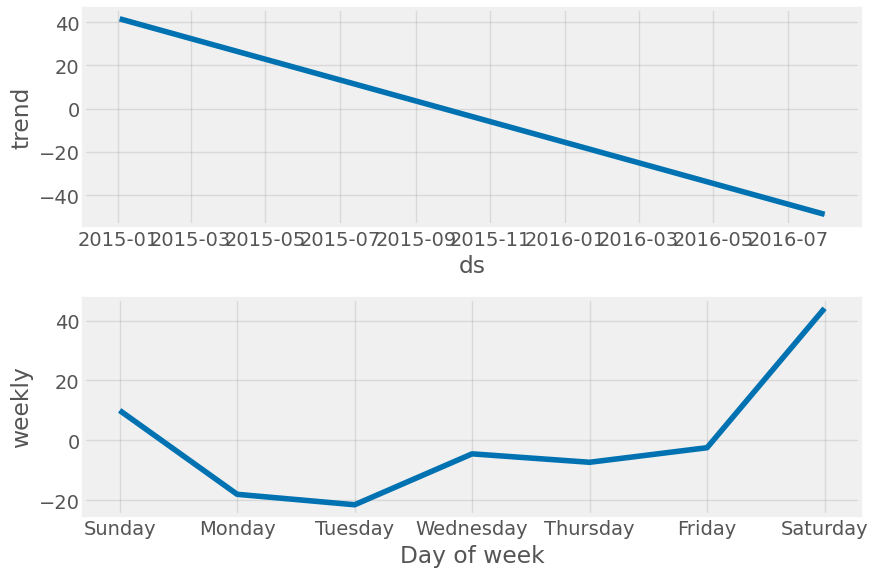

In [36]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

COMPARE FORECAST TO ACTUALS

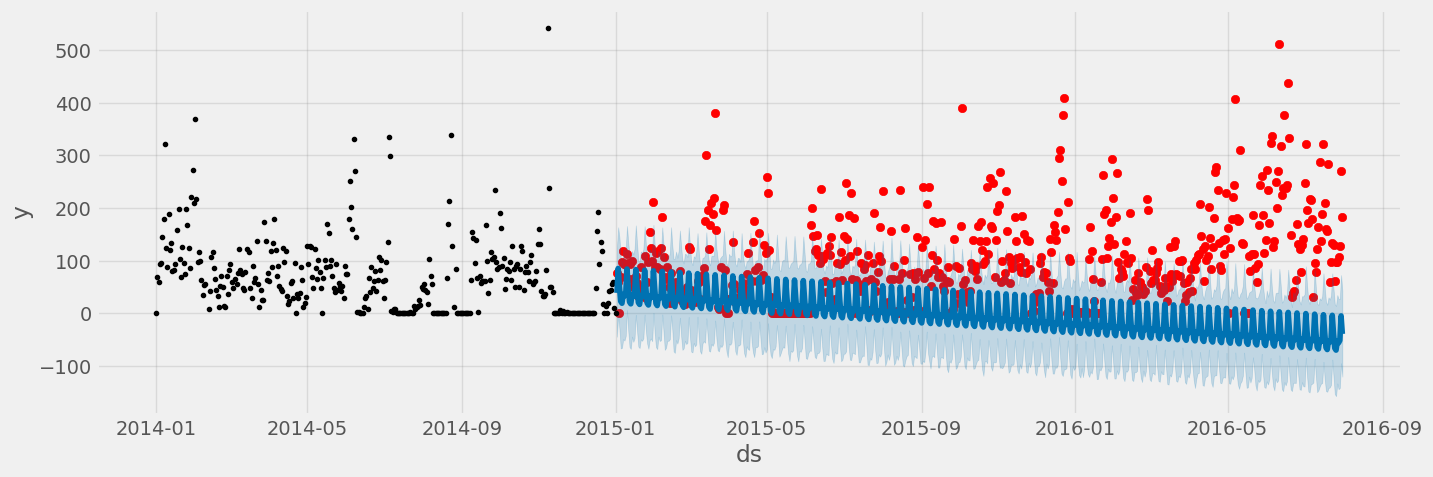

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['venda'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

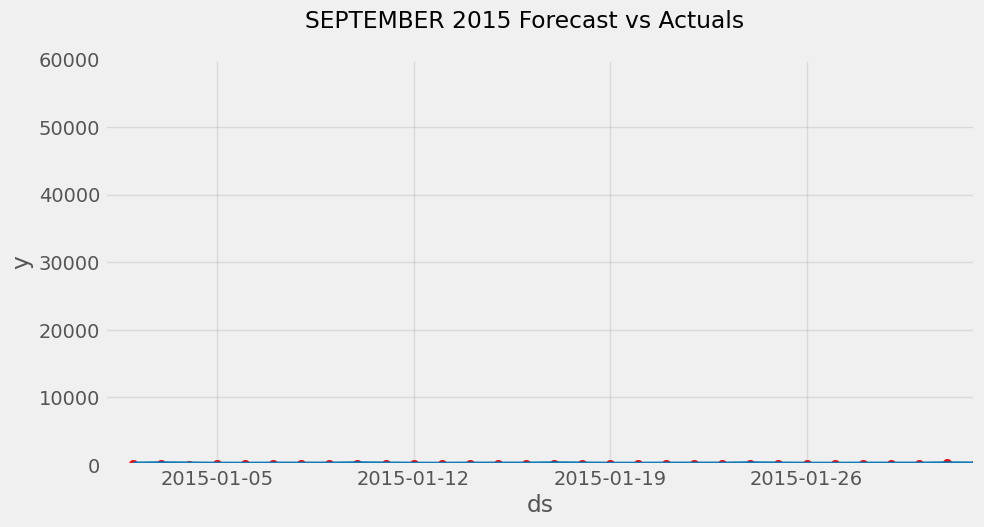

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['venda'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([pd.to_datetime('01-01-2015'), pd.to_datetime('02-01-2015')])
ax.set_ylim(0, 60000)
plot = plt.suptitle('SEPTEMBER 2015 Forecast vs Actuals')

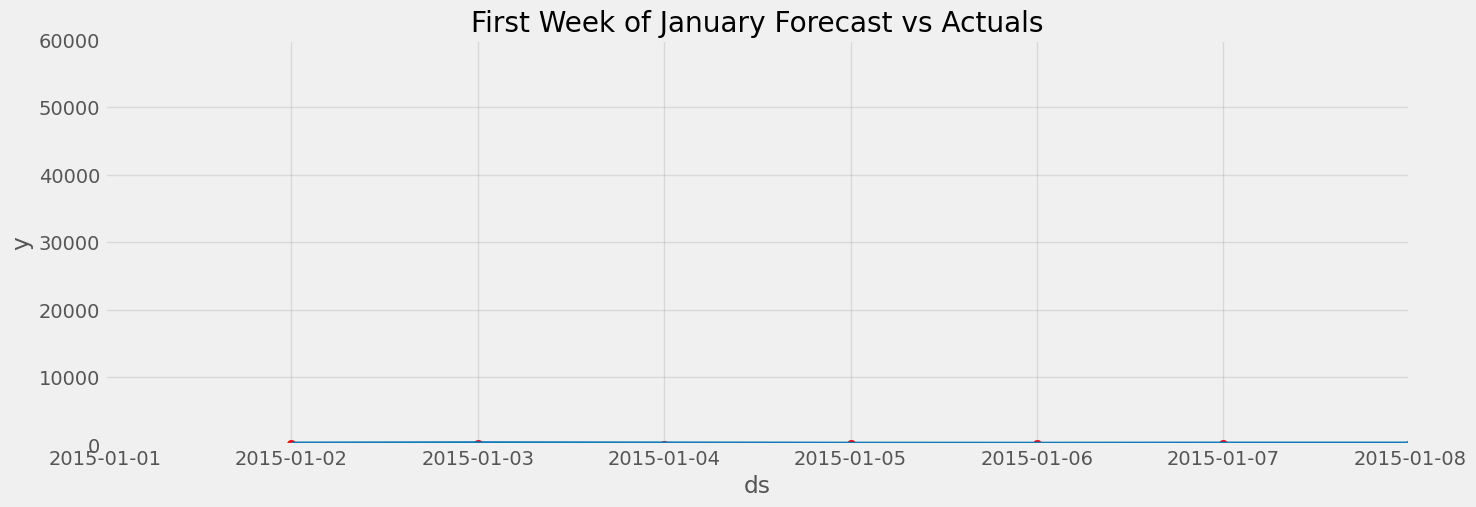

In [69]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['venda'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([pd.to_datetime('01-01-2015'), pd.to_datetime('01-08-2015')])
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

EVALUATE THE MODEL WITH ERROR METRICS

In [49]:
np.sqrt(mean_squared_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst['yhat']))

np.float64(141.13696895207477)

In [51]:
mean_absolute_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst['yhat'])

110.33912069961053

In [53]:
mean_absolute_percentage_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(inf)

ADDING HOLIDAYS

In [54]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [55]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7icd2v_/hnja07uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7icd2v_/y6h0jwju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76851', 'data', 'file=/tmp/tmp_7icd2v_/hnja07uv.json', 'init=/tmp/tmp_7icd2v_/y6h0jwju.json', 'output', 'file=/tmp/tmp_7icd2v_/prophet_model_kwba48t/prophet_model-20250920164218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 62.9 ms, sys: 1.95 ms, total: 64.8 ms
Wall time: 108 ms


In [56]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

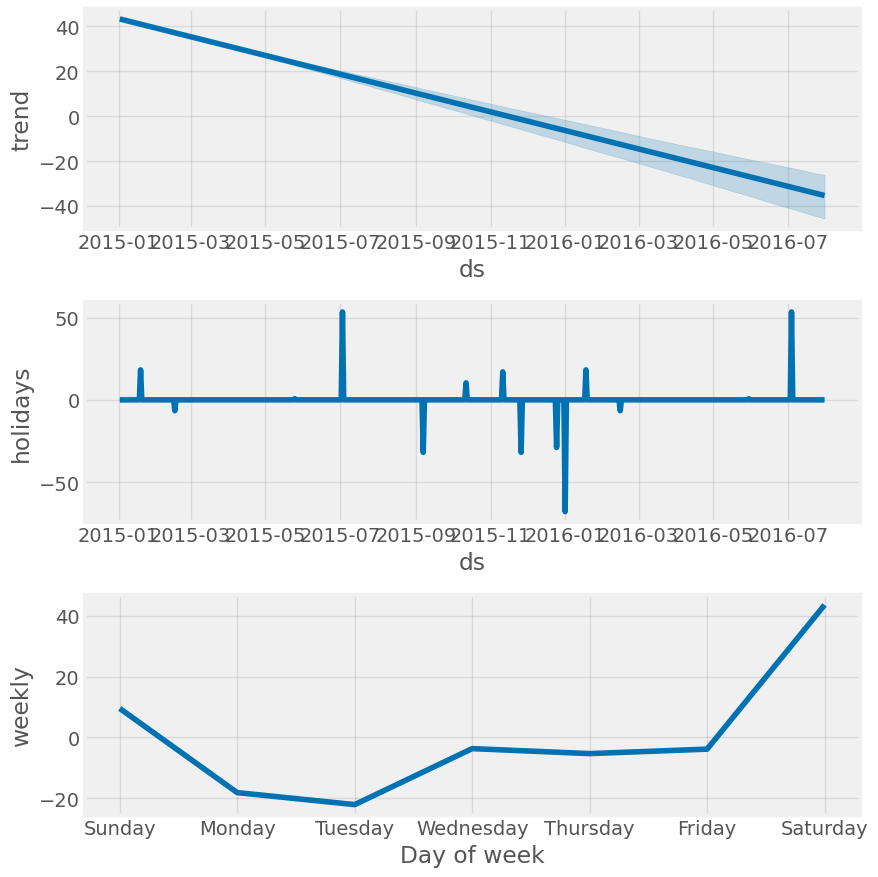

In [57]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

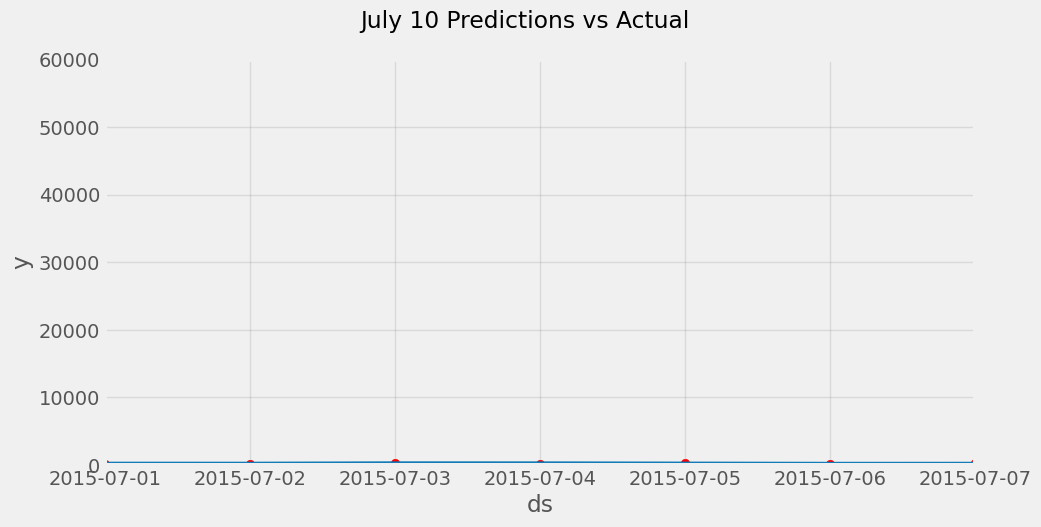

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['venda'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xlim([pd.to_datetime('07-01-2015'), pd.to_datetime('07-07-2015')])
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 10 Predictions vs Actual')

In [71]:
np.sqrt(mean_squared_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

np.float64(134.0932839932721)

In [72]:
mean_absolute_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

103.82546028823737

In [73]:
mean_absolute_percentage_error(y_true=pjme_test['venda'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

np.float64(inf)

PREDICT INTO THE FUTURE

In [74]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [75]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,-30.987203
1,2015-01-01 02:00:00,-32.041085
2,2015-01-01 03:00:00,-33.076872
3,2015-01-01 04:00:00,-34.079097
4,2015-01-01 05:00:00,-35.032285
